# Using The Power Of Data Science To Become More Effective As A Coach

Note: This notebookis a companion to the article _Data Science and Coaching: A Happy Marriage?_ published in __AgileNXT__ second edition (June 2019) by Xebia.

“How do I know I’m effective?” This is the question I often ask myself. And I’m sure my clients also want to know. In __Data Science and Coaching: A Happy Marriage/Couple?__ We read how John approached this challenge. Here we describe the steps John took to analyze the data for teams Jupiter and Saturn.

## Set-up
Let’s load some packages that we need later on.

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Gnuplot, as: G

Gnuplot

## Customer’s Needs

I find it most straightforward to look at teams from the customer’s point of view and consider the service(s) that the team offers. The customer has a request and is interested in any of (a) the time to wait until the request is fulfilled, (b) the number of completed requests per unit of time (days, weeks, ...), or (c) the time between two consecutive deliveries. We focus the analysis on (b), also known as _‘Delivery Rate’_, for team Jupiter.

## Collect Team Data

It all starts by collecting team data. Jupiter has a backlog of customer requests waiting to be fulfilled. At 2-week periods we count the number of requests completed and accepted by the customer. The team has been keeping track of this for almost 1 year. John extracted these counts from their electronic tool:

In [2]:
jupiter = [51, 49, 51, 49, 67, 37, 9, 18, 24, 15, 12, 34, 62, 79, 20, 15, 24, 29, 39, 14]

[51, 49, 51, 49, 67, 37, 9, 18, 24, 15, 12, 34, 62, 79, 20, 15, 24, 29, 39, 14]

This shows the _Delivery Rate_ ordered from most recent to past. A common way of looking at the dat is through a _frequency chart_.

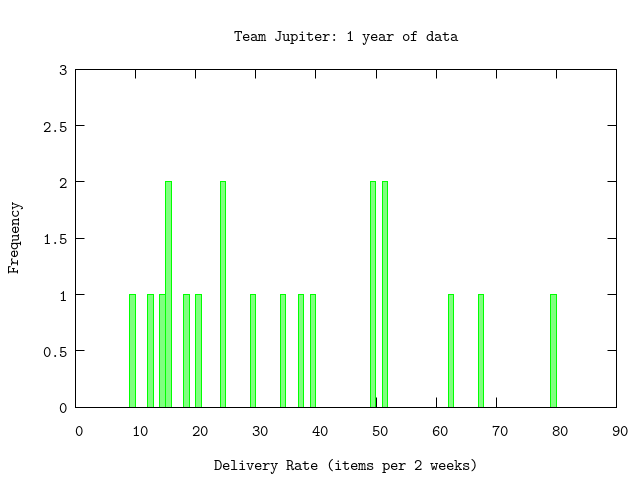

In [3]:
P.histogram(jupiter,
    plottitle: "Team Jupiter: 1 year of data",
    xlabel: "Delivery Rate (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:3]')
:"this is an inline image"

A _frequency chart_ shows how often a certain _Delivery Rate_ occurs. For team Jupiter a rate of around 25 is counted twice, while a rate of 80 completed requests in a 2-week period occurred only once. The chart does not tell us anything of the order in which the rates happened.

## Jupiter’s Data Seen As A Probability Distribution

Another way of examining the data is to view the team as a ‘black box’. We just look at the team from a customer’s point of view. The customer does not know how the team operates, what agreements they have, nor the type of framework. The customer does not care either. At each period the customer just notices the number of fulfilled orders, i.e. the _Delivery Rate_. And this number varies: most of the times around 40, 50, less often 20-ish, sometimes in the tens, and very rarely 80-ish. Mathematically this is what a distribution is.

Once John extracts the data, he creates a _Cumulative Distribution Function_ (CDF) of it. In this case we use a `binsize` of 5. This is a bit arbitrary and needs some experimentation in practice. Instead of counting how often a _Delivery Rate_ of exactly 19 occurs, we can also count the number of times a rate between 15-20 (exclusive) occurs.

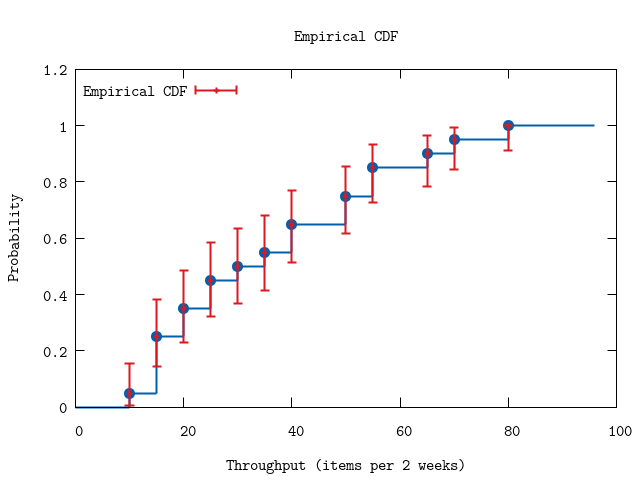

In [4]:
binsize = 5
hdata = U.to_bins jupiter, {binsize,0}

P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:100]')
:"this is an inline image"

Consider a _Delivery Rate_ of 60 or less. Look at the 60 on the horizontal axis, go up to the blue line and then to the left until the vertical axis. It meets this axis slightly above the 0.8. This means there is an 80% chance for the customer to get 60 or less completed requests. Or, equivalently, a 20% chance for 60 or more fulfilled requests in one period.

The error bars are shown in red and indicate where the ‘true’ probability distribution is that underlies the data. Notice that the height of the error bars above the data point is different from the height of the error bar below the data point. These ae known as 'asymmetrical errors' and need special care.

John assumes a Poisson distribution to model the data. This distribution has 1 parameter: the _Delivery Rate_. Let’s see how well this function describes Jupiter’s data. 


In [13]:
model = D.model "poisson"
options = [model: :linear, bin: binsize, fitmodel: model, probes: 10_000, init: [{0.1,100}]]
:"do not show this result in output"

After settings these parameters, John does a ‘Chi-squared’ fit to the model against the data considering the uncertainties in the data (red error bars).

In [15]:
hdata = U.to_bins jupiter, {binsize,0}
result = {_,_,parameters,_} = F.chi2fit hdata, {[50.0], model[:fun], &F.nopenalties/2}, 10, model: :linear
U.display(hdata,model,result,options)

Final:
    chi2:		12665898.565885413
    Degrees of freedom:	11
    gradient:		[1.7684296338465672e-4]
    parameters:		[35.35030955694681]
    errors:		[0.0052524948643270265]
    ranges:
			chi2:		12665898.565885413	-	12665898.565885425
			parameter:	35.35030955576721	-	35.350309558513594


:ok

The output shows several things. Two are very important as a first check on the quality of the fit:

1. `chi2` - 'Chi-squared' statistic; should be close to 1 per degree of freedom,
1. `gradient` - the gradient (a vector of slopes) at the minimum; should be very close to zero.

The important thing to look at is the ‘Chi2-squared’ statistic: 1763516.... This is a very strong indication that the model does not describe the data. For a good ‘fit’ we expect its value to be around 10-20.

## Assumptions For The Poisson Distribution

One of the base assumptions for the chosen model, is that the _Delivery Rate_ is constant over time. Next, John will look for changes in the rate over time.

In [16]:
# Generate a countless number of intervals. The intervals alternate between 1-15 (inclusive) of the month,
# and the 16-end of the month.
intervals = U.intervals()

# Find points in the delivery dates that indicate a change in the model
trends = F.find_all(jupiter, options) |> Enum.into([])
:"do not show this result in output"

Create a formatted table of the result:

In [22]:
trends
|> Stream.transform(1, fn arg={_,_,jupiter}, index ->
    { [{arg, Enum.at(intervals,index)}], index+length(jupiter) }
  end)
|> Enum.map(fn {{chi, [rate], sub}, date} ->
    [
      Timex.format!(date,~S({Mshort} {D}, {YYYY})),
      Float.round(chi,4),
      Float.round(rate,1),
      "#{inspect(sub, charlists: :as_lists)}"
    ]
  end)
|> U.as_table({"End date of sequence", "Goodness of fit", "Delivery Rate", "Subsequence"})
:"do not show this result in output"

End date of sequence|Goodness of fit|Delivery Rate|Subsequence             
--------------------|---------------|-------------|------------------------
May 16, 2019        |0.0363         |49.6         |[51, 49, 51, 49, 67, 37]
Feb 16, 2019        |0.9505         |17.5         |[9, 18, 24, 15, 12, 34] 
Nov 16, 2018        |0.0006         |65.2         |[62, 79]                
Oct 16, 2018        |2.3973         |21.1         |[20, 15, 24, 29, 39, 14]


The table clearly shows that the _Delivery Rate_ changes a couple of times. For each subsequence of data there is a very good fit for the Poisson distribution.

The downside is, is that our data set reduces from 20 points to a merely 6!

## Coaching Effectiveness

[Table](#Assumptions-For-The-Poisson-Distribution) reveals 3 moments in time where the chosen model changes. The effect is a jump in the parameter of the model. The most likely explanation is that team Jupiter altered their behaviour. For the good or the bad. This is something that we don't know. All we know is that from the outside we observe their changed behaviour.

Another question is whether this is caused by the coaching. This is hard to tell. Turning it around we would expect that interventions (as a result of coaching) will change behaviour. If this change is not reflected in a change of the parameter of the model we can't distinguish - from the outside - between doing interventions and doing nothing.

## New Data Set

Let’s draw a _frequency chart_ once again but now with the data set running from Feb 16, 2019 - May 16, 2019.
The result is depicted below.

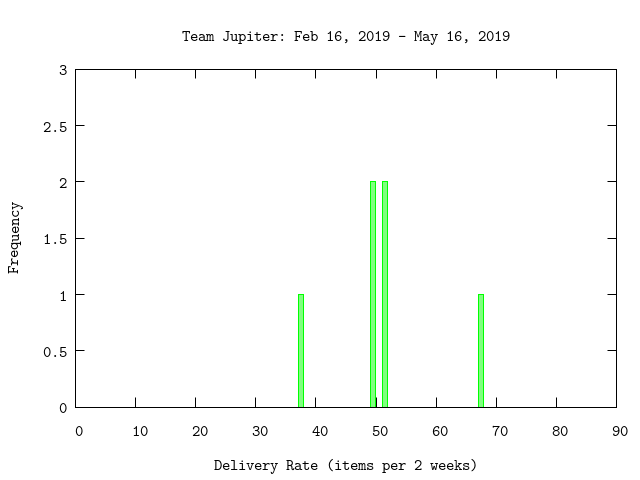

In [19]:
data = [51, 49, 51, 49, 67, 37]
P.histogram(data,
    plottitle: "Team Jupiter: Feb 16, 2019 - May 16, 2019",
    xlabel: "Delivery Rate (items per 2 weeks)",
    ylabel: "Frequency",
    xrange: '[0:90]',
    yrange: '[0:3]')
:"this is an inline image"

Fitting the model against the reduced data set gives:

In [21]:
hdata = U.to_bins data, {binsize,0}
result = {_,[[err2]],[rate],_} = F.chi2fit hdata, {[50.0], model[:fun], &F.nopenalties/2}, 10, model: :linear
U.display(hdata,model,result,options)

Final:
    chi2:		0.03628574276222344
    Degrees of freedom:	3
    gradient:		[-1.2591532801592725e-12]
    parameters:		[49.64029593880198]
    errors:		[4.921082327812432]
    ranges:
			chi2:		0.03628574276222344	-	0.04471758530730531
			parameter:	49.292239883465776	-	50.09320580505252


:ok

An excellent fit! This is confirmed by the ‘Chi-squared’ statistic of 0.03... Actually, the fit is too good. Usually this is caused by relatively large error bars originating from too few data points. Nevertheless, the Delivery Rate is estimated as 3.0 – 3.6 fulfilled requests per (calendar) day. The CDF with the fitted curve is shown below.

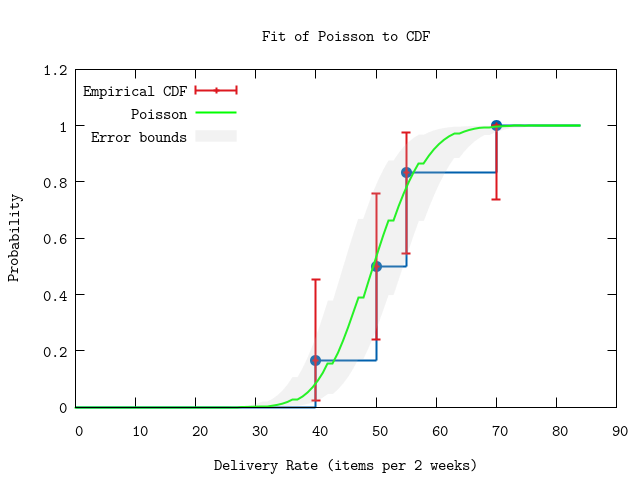

In [24]:
error = :math.sqrt(err2)
P.ecdf(hdata,
    plottitle: "Fit of Poisson to CDF",
    xlabel: "Delivery Rate (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:90]',
    title: "Poisson",
    bounds: {D.poissonCDF(rate-error),D.poissonCDF(rate+error)},
    func: D.poissonCDF(rate))
:"this is an inline image"

## Forecasting

As demonstrated in the previous section, after determining the most recent subsequence of data that is compatible with non-changing team behaviour we're left with a small number of data points. Despite the fact that we only have a few data points, this determines the _Delivery Rate_ reasonably well.

The parameter (with errors) can be used to do forecasting. Have a look at one of the other notebooks to start forecasting!